# Notebook config

In [ ]:
#@markdown #**SETUP FOR TEST NOTEBOOK**
#@markdown ---

# Cell 0: ENVIRONMENT DETECTION & CONFIGURATION
import os
import sys
import subprocess

# Detect if running in Colab
RUNNING_IN_COLAB = 'google.colab' in sys.modules

if RUNNING_IN_COLAB:
    BASE_DIR = '/content'
    # Clone the RatTrack repo if missing
    REPO_URL = 'https://github.com/leomaestri/RatTrack.git'
    REPO_DIR = os.path.join(BASE_DIR, 'RatTrack')
    if not os.path.exists(REPO_DIR):
        subprocess.run(['git', 'clone', REPO_URL, REPO_DIR], check=True)

    # Paths to model and test video
    MODEL_PATH = os.path.join(REPO_DIR, 'data', 'model.pt')
    VIDEO_PATH = os.path.join(REPO_DIR, 'data', 'test_video.MP4')

    !cp {MODEL_PATH} "/content/model.pt"
    MODEL_PATH = "/content/model.pt"
    !cp {VIDEO_PATH} "/content/test_video.MP4"
    VIDEO_PATH = "/content/test_video.MP4"
else:
    #@markdown **Ignore if using Colab**
    #@markdown Enter the path where your local RatTrack repo lives (e.g. ~/projects/RatTrack)
    local_repo_path = ""  #@param {type:"string"}
    REPO_DIR = os.path.expanduser(local_repo_path or '~/proyecto/RatTrack')

    # Paths to model and test video
    MODEL_PATH = os.path.join(REPO_DIR, 'data', 'model.pt')
    VIDEO_PATH = os.path.join(REPO_DIR, 'data', 'test_video.MP4')

!pip install -r {REPO_DIR}/requirements.txt

print(f"Model path: {MODEL_PATH}")
print(f"Test video: {VIDEO_PATH}")

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

In [ ]:
import cv2
import glob
import yaml
import random
import shutil
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load and format video



To reduce processing time and operations we will:
* Reduce FPS (Frames Per Second) to 10
* Crop the image only to the relevant part of the video
* Start from the relevant moment of the video

In [ ]:
# Load from drive if needed, otherwise just load on notebook Files directly

#from google.colab import drive
#drive.mount('/content/drive')
#!cp -r "/content/drive/MyDrive/..." "/content/"

In [ ]:
# Open video and extract metadata
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"No pude abrir {VIDEO_PATH}")

fps         = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width       = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height      = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Read a frame to check channels
ret, frame = cap.read()
if not ret:
    raise RuntimeError("No pude leer el primer frame")
channels = frame.shape[2]  # usually 3 (BGR)

print(f"Vídeo: {VIDEO_PATH}")
print(f"  • Resolución: {width}×{height}")
print(f"  • FPS: {fps}")
print(f"  • Total frames: {frame_count}")
print(f"  • Canales por frame: {channels}")

# Release the video capture
cap.release()

Vídeo: /content/MAH01568.MP4
  • Resolución: 1280×720
  • FPS: 29.97002997002997
  • Total frames: 10260
  • Canales por frame: 3


In [ ]:
# Reduce FPS to 10
!ffmpeg -i {VIDEO_PATH} -vf fps=10 ./video_to_10fps.mp4

print(f"Change FPS from {fps} to 10")

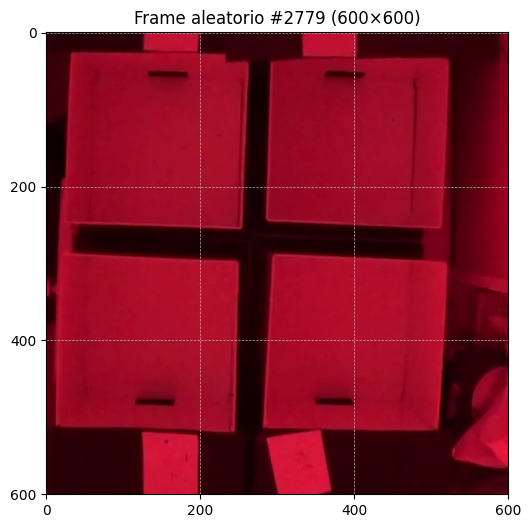

In [ ]:
VIDEO_PATH = './video_to_10fps.mp4'
cap = cv2.VideoCapture(VIDEO_PATH)

# 1) Check that the video opened successfully
if not cap.isOpened():
    cap.release()
    raise IOError(f"Could not open the video: {VIDEO_PATH}")

# 2) Get the total number of frames and verify it's > 0
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
if total_frames <= 0:
    cap.release()
    raise ValueError(f"No frames found in the video (total_frames={total_frames})")

# 3) Select a random index between 0 and total_frames-1
rand_idx = random.randint(0, total_frames - 1)

# 4) Seek to that frame and read it
cap.set(cv2.CAP_PROP_POS_FRAMES, rand_idx)
ret, frame = cap.read()
cap.release()

if not ret or frame is None:
    raise RuntimeError(f"Error reading frame #{rand_idx}")

# 5) Convert BGR→RGB and display it
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
h, w, _ = frame_rgb.shape

plt.figure(figsize=(10, 6))
plt.imshow(frame_rgb)
plt.title(f'Random frame #{rand_idx} ({w}×{h})')

# Adjust ticks every 50 pixels to avoid clutter
plt.xticks(range(0, w+1, 50))
plt.yticks(range(0, h+1, 50))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

print(f"From the random frame of the image, save the upper left and bottom right corners to crop the video with a square")
print(f"You will use the corners on the following cells with the format (x, y)")

Ingresa x1,y1,x2,y2 (ej: 100,50,1180,650): 300, 100, 900, 700


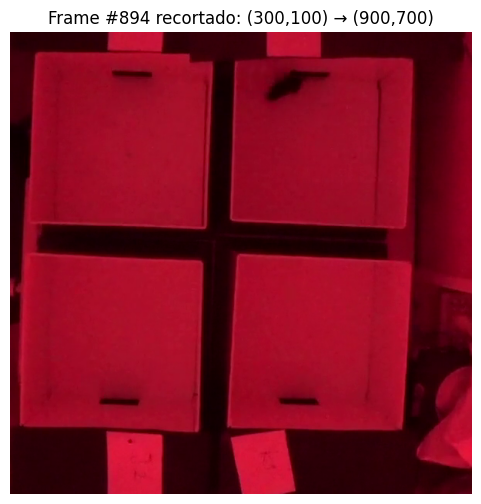

¿Está bien este recorte? (s/n): s
Ejecutando recorte en todo el vídeo...
Vídeo recortado guardado en: /content/MAH01568_cropped.mp4


In [ ]:
# Get total frames
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {VIDEO_PATH}")
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

def preview_crop(x1, y1, x2, y2):
    """Display a random frame cropped according to the given coordinates."""
    cap = cv2.VideoCapture(VIDEO_PATH)
    idx = random.randint(0, total_frames - 1)
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        print(f"Could not read frame #{idx}")
        return
    crop = frame[y1:y2, x1:x2]
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.title(f'Frame #{idx} cropped: ({x1},{y1}) → ({x2},{y2})')
    plt.axis('off')
    plt.show()

# Interactive input and confirmation loop
while True:
    coords = input("Enter x1,y1,x2,y2 (e.g.: 100,50,1180,650): ")
    try:
        x1, y1, x2, y2 = map(int, coords.strip().split(','))
    except:
        print("Invalid format. Please enter four integers separated by commas.")
        continue

    preview_crop(x1, y1, x2, y2)
    confirm = input("Is this crop OK? (y/n): ")
    if confirm.lower() == 'y':
        break

# Execute full video crop with FFmpeg
width, height = x2 - x1, y2 - y1
output_path = './video_to_10fps_cropped.mp4'
cmd = (
    f'ffmpeg -i "{VIDEO_PATH}" '
    f'-filter:v "crop={width}:{height}:{x1}:{y1}" '
    f'-c:a copy "{output_path}"'
)
print("Running crop on the entire video...")
os.system(cmd)
print(f"Cropped video saved to: {output_path}")

# Inference on preprocessed video

In [ ]:
# -- Adjust these paths --
VIDEO_IN     = './video_to_10fps_cropped.mp4'
OUT_DIR      = './inference'
OUT_VIDEO    = os.path.join(OUT_DIR, 'annotated.mp4')
N_FRAMES_REF = 3     # how many random frames to save

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(f'{OUT_DIR}/frames', exist_ok=True)
os.makedirs(f'{OUT_DIR}/labels', exist_ok=True)

# 1) get total frames, FPS, and dimensions
cap = cv2.VideoCapture(VIDEO_IN)
total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps   = cap.get(cv2.CAP_PROP_FPS)
w     = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h     = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

refs = set(random.sample(range(total), N_FRAMES_REF))
print(f"Reference frames (no overlay): {sorted(refs)}  FPS={fps:.2f}, total={total}, size={w}×{h}")

# 2) prepare writer for annotated video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(OUT_VIDEO, fourcc, fps, (w, h))

# 3) load OBB model
model = YOLO(MODEL_PATH)

# 4) streaming OBB inference
for i, r in enumerate(tqdm(model.predict(
        source=VIDEO_IN, stream=True, conf=0.25, imgsz=640, task='obb'
    ))):
    # extract polygons and xywhr parameters
    if r.obb is not None and len(r.obb.xyxyxyxy):
        polys  = r.obb.xyxyxyxy.cpu().numpy().reshape(-1,8).astype(int)  # N×8
        clses  = r.obb.cls  .cpu().numpy().astype(int)                    # N
        confs  = r.obb.conf .cpu().numpy()                               # N
    else:
        polys = np.zeros((0,8), int)
        clses = np.zeros((0,),   int)
        confs = np.zeros((0,), float)

    # dump .txt with: cls x1 y1 x2 y2 x3 y3 x4 y4 conf
    lbl_path = f'{OUT_DIR}/labels/frame_{i:06d}.txt'
    with open(lbl_path, 'w') as f:
        for poly, cls, conf in zip(polys, clses, confs):
            coords = ' '.join(map(str, poly.tolist()))
            f.write(f"{cls} {coords} {conf:.3f}\n")

    # get the original BGR frame
    orig_frame = r.orig_img.copy()

    # save reference frames *without overlay*
    if i in refs:
        cv2.imwrite(f'{OUT_DIR}/frames/frame_{i:06d}.png', orig_frame)

    # draw only the OBB polygon on all other frames
    frame = orig_frame.copy()
    for poly in polys:
        pts = poly.reshape(4,2)
        cv2.polylines(frame, [pts], isClosed=True, color=(0,255,0), thickness=2)

    # write the annotated frame to the video
    writer.write(frame)

# close the writer
writer.release()

# 5) compress everything into a ZIP
zip_path = shutil.make_archive(OUT_DIR, 'zip', OUT_DIR)

print("-----OBB inference complete-----")
print(f" Labels in {OUT_DIR}/labels")
print(f"Reference frames (no overlay) in {OUT_DIR}/frames")
print(f"Annotated video at {OUT_VIDEO}")
print(f"Everything archived to {zip_path}")